### IMPORT LIBS

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import random
import numpy as np
import scipy.io as scio
import pandas as pd
import os
import collections
from matplotlib import pyplot as plt

from keras import optimizers
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv1D, BatchNormalization, MaxPooling1D
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from qkeras import *

import math

Using TensorFlow backend.


### PATH

In [2]:
base_path = '/home/wzx/ECGAI/EXP1/1D_CNN'

dataset_path =  '/home/wzx/ECGAI/EXP1/Dataset/' # Training data

### PLOT SETTING

In [3]:
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

### FUNCTIONS

### LAYERS

In [4]:
def nn_base(Unit, Kernel, Conv_Stride, Maxpool_Stride, input_tensor = None, wei = 4):
    
    input_shape = (None, 3)

    ecg_input = input_tensor

    bn_axis = 3

    # nn_base
    x = QConv1D(filters = Unit, kernel_size = Kernel, padding = 'same', strides = Conv_Stride, 
                kernel_quantizer=quantized_bits(wei,0,1), bias_quantizer=quantized_bits(wei,0,1),
               data_format='channels_last')(ecg_input)
    x = QActivation("quantized_relu(4,0)")(x)
    
    # x = BatchNormalization()(x)
    
    x = MaxPooling1D(pool_size = 2, strides = Maxpool_Stride, padding = 'same', 
                     data_format='channels_last')(x)

    return x

In [5]:
def classifier_layer(base_layer, dropout_rate = 0.1, ClassesNum = 17, wei = 4):
    
    # classifier layers
    x = QConv1D(filters = 32, kernel_size = 10, padding = 'same', 
                kernel_quantizer=quantized_bits(wei,0,1), bias_quantizer=quantized_bits(wei,0,1),
               name = 'classifier_layer_Conv1D1', data_format='channels_last')(base_layer)
    x = QActivation("quantized_relu(4,0)", name = 'QActivation_relu1')(x)
    
    x = QConv1D(filters = 128, kernel_size = 5, padding = 'same', 
                kernel_quantizer=quantized_bits(wei,0,1), bias_quantizer=quantized_bits(wei,0,1),
               strides = 2, name = 'classifier_layer_Conv1D2', data_format='channels_last')(x)
    x = QActivation("quantized_relu(4,0)", name = 'QActivation_relu2')(x)
    
    x = MaxPooling1D(pool_size = 2, strides = 2, padding = 'same', 
                     name = 'classifier_layer_MaxPooling1D1', data_format='channels_last')(x)
    
    x = QConv1D(filters = 256, kernel_size = 15, padding = 'same', 
                kernel_quantizer=quantized_bits(wei,0,1), bias_quantizer=quantized_bits(wei,0,1),
               name = 'classifier_layer_Conv1D3', data_format='channels_last')(x)
    x = QActivation("quantized_relu(4,0)", name = 'QActivation_relu3')(x)
    
    x = MaxPooling1D(pool_size = 2, strides = 2, padding = 'same', 
                     name = 'classifier_layer_MaxPooling1D2', data_format='channels_last')(x)
    
    x = QConv1D(filters = 512, kernel_size = 5, padding = 'same', 
                kernel_quantizer=quantized_bits(wei,0,1), bias_quantizer=quantized_bits(wei,0,1),
               name = 'classifier_layer_Conv1D4', data_format='channels_last')(x)
    x = QActivation("quantized_relu(4,0)", name = 'QActivation_relu4')(x)
    
    x = QConv1D(filters = 128, kernel_size = 3, padding = 'same',
                kernel_quantizer=quantized_bits(wei,0,1), bias_quantizer=quantized_bits(wei,0,1),
               name = 'classifier_layer_Conv1D5', data_format='channels_last')(x)
    x = QActivation("quantized_relu(4,0)", name = 'QActivation_relu5')(x)
    
    
    x = Flatten(name = 'classifier_layer_Flatten')(x)
    
    x = QDense(units = 512, 
               kernel_quantizer=quantized_bits(wei,0,1), bias_quantizer=quantized_bits(wei,0,1),
               name = 'classifier_layer_Dense1')(x)
    x = QActivation("quantized_relu(4,0)", name = 'QActivation_relu6')(x)
    
    x = Dropout(rate = dropout_rate, name = 'classifier_layer_Dropout')(x)
    
    x = QDense(units = ClassesNum, 
               kernel_quantizer=quantized_bits(wei,0,1), bias_quantizer=quantized_bits(wei,0,1),
               name = 'classifier_layer_Dense2')(x)
    x = Activation("softmax", name="softmax")(x)
    
    return x

### DATA PROCESSING

In [6]:
# Variables

classes = ['NSR', 'APB', 'AFL', 'AFIB', 'SVTA', 'WPW','PVC', 'Bigeminy', 'Trigeminy', 
           'VT', 'IVR', 'VFL', 'Fusion', 'LBBBB', 'RBBBB', 'SDHB', 'PR']
ClassesNum = len(classes)

X = list()
y = list()

for root, dirs, files in os.walk(dataset_path, topdown=False):
    for name in files:
        data_train = scio.loadmat(os.path.join(root, name))# 取出字典里的value
        
        # arr -> list
        data_arr = data_train.get('val')
        data_list = data_arr.tolist()
        
        # z-score normalization
        sum = 0
        max = 0
        for i in range(len(data_list[0])):
            sum = data_list[0][i] + sum
        average = float(sum/len(data_list[0]))
        total = 0
        for value in data_list[0]:
            total += (value - average) ** 2
        stddev = math.sqrt(total/len(data_list))
        data_list[0] = [(x-average)/stddev for x in data_list[0]]
        
        X.append(data_list[0]) # [[……]] -> [ ]
        y.append(int(os.path.basename(root)[0:2]) - 1)  # name -> num

### START TRAINING

In [7]:
# list -> arr
X=np.array(X)
y=np.array(y)

print("total num of training data : ", len(X))

# get X_train, X_test, y_train, y_test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("X_train : ", len(X_train))
print("X_test  : ", len(X_test))
print("y_train : ", collections.Counter(y_train))
print("y_test  : ", collections.Counter(y_test))
print("shape of X_train : ", np.shape(X_train[0]))
print("shape of y_train : ", np.shape(y_train))
print("shape of X_test : ", np.shape(X_test))
print("shape of y_test : ", np.shape(y_test))

total num of training data :  1000
X_train :  800
X_test  :  200
y_train :  Counter({0: 234, 3: 109, 6: 103, 13: 77, 1: 50, 14: 50, 7: 42, 16: 38, 5: 18, 2: 17, 12: 10, 4: 10, 8: 10, 15: 9, 10: 8, 11: 8, 9: 7})
y_test  :  Counter({0: 49, 6: 30, 3: 26, 13: 26, 1: 16, 7: 13, 14: 12, 16: 7, 2: 3, 8: 3, 5: 3, 4: 3, 9: 3, 10: 2, 11: 2, 12: 1, 15: 1})
shape of X_train :  (3600,)
shape of y_train :  (800,)
shape of X_test :  (200, 3600)
shape of y_test :  (200,)


### BUILD MODEL_SEQ

In [8]:
model_all = Sequential()
model_all.add(Conv1D(128, 50, padding = 'same', activation='relu', strides = 3,
                     input_shape=(3600,1), data_format='channels_last'))
model_all.add(BatchNormalization())
model_all.add(MaxPooling1D(3, padding = 'same', data_format='channels_last'))

model_all.add(Conv1D(32, 7, padding = 'same', activation='relu', strides = 1, data_format='channels_last'))
model_all.add(BatchNormalization())
model_all.add(MaxPooling1D(2, padding = 'same', data_format='channels_last'))

model_all.add(Conv1D(32, 10, padding = 'same', activation='relu', strides = 1, data_format='channels_last'))
model_all.add(Conv1D(128, 5, padding = 'same', activation='relu', strides = 2, data_format='channels_last'))
model_all.add(MaxPooling1D(2,padding = 'same', data_format='channels_last'))

model_all.add(Conv1D(256, 15, padding = 'same', activation='relu', strides = 1, data_format='channels_last'))
model_all.add(MaxPooling1D(2, padding = 'same', data_format='channels_last')) 

model_all.add(Conv1D(512, 5, padding = 'same', activation='relu', strides = 1, data_format='channels_last'))
model_all.add(Conv1D(128, 3, padding = 'same', activation='relu', strides = 1, data_format='channels_last'))
model_all.add(Flatten(data_format='channels_last'))

model_all.add(Dense(512, activation='relu'))
model_all.add(Dropout(0.1))
model_all.add(Dense(ClassesNum, activation='softmax'))

print(model_all.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1200, 128)         6528      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1200, 128)         512       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 400, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 400, 32)           28704     
_________________________________________________________________
batch_normalization_2 (Batch (None, 400, 32)           128       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 200, 32)           0         
______________________________________

### BUILD MODEL_MOD

In [9]:
input_ecg = Input(shape=(3600,1))
x = nn_base(128, 50, Conv_Stride = 3, Maxpool_Stride = 3, input_tensor = input_ecg, wei = 4)
x = nn_base(32, 7, Conv_Stride = 1, Maxpool_Stride = 2, input_tensor = x, wei = 4)
output_ecg = classifier_layer(x, dropout_rate = 0.1, ClassesNum = 17, wei = 4)
model_m = Model(input_ecg, output_ecg)
print(model_m.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3600, 1)           0         
_________________________________________________________________
q_conv1d_1 (QConv1D)         (None, 1200, 128)         6528      
_________________________________________________________________
q_activation_1 (QActivation) (None, 1200, 128)         0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 400, 128)          0         
_________________________________________________________________
q_conv1d_2 (QConv1D)         (None, 400, 32)           28704     
_________________________________________________________________
q_activation_2 (QActivation) (None, 400, 32)           0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 200, 32)           0   

### SETTING OPTIMIZERS & COMPILE

In [10]:
# setting optimizers & compile
optimizers.Adam(lr = 0.01, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
# model_all.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_m.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# expand X_train dims
X_train = np.expand_dims(X_train, axis=2)
X_test = np.reshape(X_test, (np.shape(X_test)[0], np.shape(X_test)[1], 1))
# Y : int -> binary (one-hot)
y_train = to_categorical(y_train,num_classes = ClassesNum)
y_test = to_categorical(y_test,num_classes = ClassesNum)

display(np.shape(X_train))

(800, 3600, 1)

### TRAINING 

In [11]:
BATCH_SIZE = 16
EPOCHS = 50
# history = model_all.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS)
history = model_m.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/50
800/800 [==============================] - 7s 9ms/step - loss: 2.4239 - accuracy: 0.2725
Epoch 2/50
800/800 [==============================] - 7s 8ms/step - loss: 2.2150 - accuracy: 0.2925
Epoch 3/50
800/800 [==============================] - 7s 9ms/step - loss: 1.9253 - accuracy: 0.3562
Epoch 4/50
800/800 [==============================] - 8s 10ms/step - loss: 1.5319 - accuracy: 0.4762
Epoch 5/50
800/800 [==============================] - 7s 9ms/step - loss: 1.1804 - accuracy: 0.5913
Epoch 6/50
800/800 [==============================] - 7s 9ms/step - loss: 0.9434 - accuracy: 0.6925
Epoch 7/50
800/800 [==============================] - 7s 9ms/step - loss: 0.6967 - accuracy: 0.7588
Epoch 8/50
800/800 [==============================] - 7s 9ms/step - loss: 0.5064 - accuracy: 0.8363
Epoch 9/50
800/800 [==============================] - 7s 8ms/step - loss: 0.4802 - accuracy: 0.8363
Epoc

### PRINT ACC&LOSS 

In [12]:
print(history.history.keys())
print(history.history['loss'])
print(history.history['accuracy'])

dict_keys(['loss', 'accuracy'])
[2.423948259353638, 2.215043296813965, 1.9253125262260438, 1.5318781447410583, 1.180393726825714, 0.9433964276313782, 0.6967418426275254, 0.5064331483840943, 0.48016825556755066, 0.34969711549580096, 0.2656042581796646, 0.2014003974944353, 0.19710624061524867, 0.302267953902483, 0.1117593902349472, 0.11575125047937035, 0.05781869908794761, 0.06102100647985935, 0.03328856946900487, 0.015618561236187815, 0.03198358120396733, 0.04618866348639131, 0.017239013961516322, 0.033333075982518494, 0.07037743951193988, 0.057434636540710925, 0.020576246441341938, 0.008143487367779017, 0.0031226170109584926, 0.002228592066094279, 0.0017335997463669628, 0.001533189929323271, 0.0013760470424313098, 0.001116918483749032, 0.001083171854261309, 0.0009369975561276078, 0.0009063365263864399, 0.0007954413257539272, 0.0007410144410096109, 0.0007095119880978018, 0.0005916337994858622, 0.0005692262752563693, 0.0005462282162625343, 0.00048652597120963037, 0.0004897311140666716, 0

### PRINT PLOT 

Text(0.5, 1.0, 'acc')

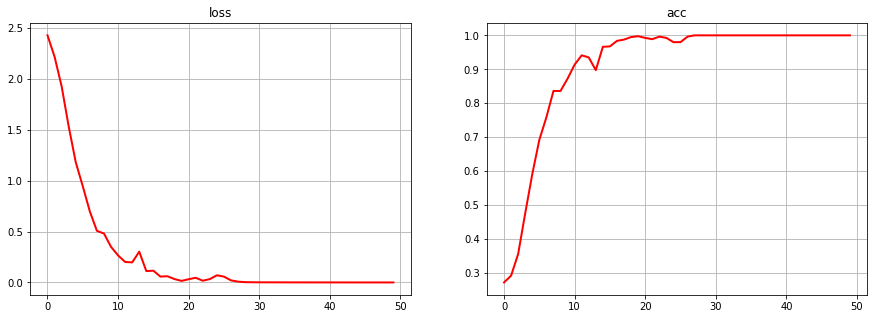

In [13]:
# put into df
record_arr = np.array([history.history['loss'][0], history.history['accuracy'][0]])
for i in range(1, EPOCHS):
    new_row = np.array([history.history['loss'][i], history.history['accuracy'][i]])
    record_arr = np.row_stack((record_arr, new_row))
    
record_df = pd.DataFrame(record_arr, columns=["loss", "acc"])

#print curve
plt.subplot(1,2,1)
plt.plot(np.arange(0, EPOCHS), record_df["loss"], 'r')
plt.title('loss')
plt.subplot(1,2,2)
plt.plot(np.arange(0, EPOCHS), record_df["acc"], 'r')
plt.title('acc')

### VAL ACC LOSS 

In [17]:
# val_loss_acc = model_all.evaluate(X_test, y_test, batch_size=100)
val_loss_acc = model_m.evaluate(X_test, y_test, batch_size = 16)
print("score of val : ", val_loss_acc[0])
print("acc of val : ", val_loss_acc[1])

200/200 [==============================] - 1s 3ms/step
score of val :  0.572066293247044
acc of val :  0.9150000214576721


### WEIGHTS 

In [15]:
outputs = []
output_names = []

for layer in model_m.layers:
    if layer.__class__.__name__ in ["QActivation", "Activation",
                                  "QDense", "QConv1D"]:
        output_names.append(layer.name)
        outputs.append(layer.output)

all_weights = []
model_save_quantized_weights(model_m)

for layer in model_m.layers:
      for w, weights in enumerate(layer.get_weights()):
            print(layer.name, w)
            all_weights.append(weights.flatten())

all_weights = np.concatenate(all_weights).astype(np.float32)
print(all_weights.size)
    
for layer in model_m.layers:
      for w, weight in enumerate(layer.get_weights()):
            print(layer.name, w, weight.shape)

print(model_m.get_weights())

... quantizing model
q_conv1d_1 0
q_conv1d_1 1
q_conv1d_2 0
q_conv1d_2 1
classifier_layer_Conv1D1 0
classifier_layer_Conv1D1 1
classifier_layer_Conv1D2 0
classifier_layer_Conv1D2 1
classifier_layer_Conv1D3 0
classifier_layer_Conv1D3 1
classifier_layer_Conv1D4 0
classifier_layer_Conv1D4 1
classifier_layer_Conv1D5 0
classifier_layer_Conv1D5 1
classifier_layer_Dense1 0
classifier_layer_Dense1 1
classifier_layer_Dense2 0
classifier_layer_Dense2 1
3058129
q_conv1d_1 0 (50, 1, 128)
q_conv1d_1 1 (128,)
q_conv1d_2 0 (7, 128, 32)
q_conv1d_2 1 (32,)
classifier_layer_Conv1D1 0 (10, 32, 32)
classifier_layer_Conv1D1 1 (32,)
classifier_layer_Conv1D2 0 (5, 32, 128)
classifier_layer_Conv1D2 1 (128,)
classifier_layer_Conv1D3 0 (15, 128, 256)
classifier_layer_Conv1D3 1 (256,)
classifier_layer_Conv1D4 0 (5, 256, 512)
classifier_layer_Conv1D4 1 (512,)
classifier_layer_Conv1D5 0 (3, 512, 128)
classifier_layer_Conv1D5 1 (128,)
classifier_layer_Dense1 0 (3200, 512)
classifier_layer_Dense1 1 (512,)
classifier

### PREDICT 

In [16]:
# predictions = model_all.predict(X_test)
predictions = model_m.predict(X_test)
display(predictions)

array([[1.9112147e-03, 4.2889165e-05, 9.7205702e-06, ..., 1.2877663e-05,
        2.6257117e-08, 2.3771251e-07],
       [2.1851793e-07, 7.5676712e-07, 9.9953985e-01, ..., 4.8582356e-06,
        4.9525767e-08, 1.1097256e-06],
       [1.6722836e-08, 2.3301272e-10, 1.8261869e-07, ..., 5.7342833e-09,
        1.3514125e-09, 9.9975950e-01],
       ...,
       [3.3212153e-05, 3.6973017e-06, 8.5964839e-06, ..., 2.5610459e-06,
        7.6896549e-07, 2.5556673e-07],
       [6.5402469e-06, 1.1365245e-06, 3.4196473e-06, ..., 4.7748978e-07,
        4.8297402e-09, 6.3124261e-08],
       [5.8626806e-06, 9.7975214e-07, 3.2124840e-06, ..., 4.7377722e-07,
        5.3880025e-09, 6.2633468e-08]], dtype=float32)